# EEG Problem Set: Analysis
This problem set requires you to have already run the `eeg-preprocessing.ipynb` notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne import set_log_level
import warnings
warnings.filterwarnings("ignore")
set_log_level(verbose=False)
%matplotlib inline

This assignment will consist of 3 parts:
- Part 1: ERP analysis
- Part 2: Time-frequency analysis
- Part 3: Experimental design question

## Part 1
### Instructions

In this problem set, you will be performing an ERP analysis and time-frequency analysis on a preprocessed dataset. First let's describe the task in greater detail. 

This experiment is based on the oddball paradigm used in [Luck et al., (2009)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-8986.2009.00817.x). In the oddball paradigm, a letter or digit was presented every 1100-1500 ms. Subjects were instructed to press a button with one hand for digits and with the other hand for letters. For a given trial block, either the letters or the digits were rare (20%) and the other category was frequent (80%). The stimulus category (digits or letters), the probability (80% or 20%) and the hand used for response (left or right) were counterbalanced, leading to 8 experimental conditions. The probability manipulation was designed to isolate the probability-sensitive P300 component. Different event codes were used for the digits when they were rare (`20_Dig_L` for response with left hand, `20_Dig_R` for response with right), the digits when they were frequent (`80_Dig_L`, `80_Dig_R`), the letters when they were rare (`20_Let_L`, `20_Let_R`), and the letters when they were frequent (`80_Let_L`, `80_Let_R`). These event codes are summarized below:

|Left/Right|Rare|Frequent|
|---|---|---|
|Digits|20_Dig_L/20_Dig_R|80_Dig_L/80_Dig_R|
|Letters|20_Let_L/20_Let_R|80_Let_L/80_Let_R|

The P300 is a neural marker of surprise. As such, we expect a larger P300 during the rare trials than for the frequent trials. In this notebook, you will analyze the difference (if any) in P300s between conditions. Specifically, you will (1a) perform permutation testing, and (1b) visualize the evoked potentials. After this, you will (2) do a time-frequency analysis to identify a signature of conflict in the theta (4-8 Hz) band.

We've included the script used for preprocessing (`eeg-preprocessing.ipynb`) and an inspector (`eeg-visualization.ipynb`) if you'd like to take a closer look at the data.

Here is a visualization of the events in the experiment, using the raw data:

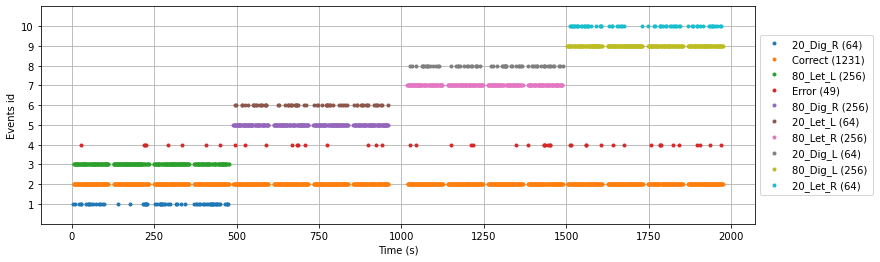

In [2]:
from mne.viz import plot_events
from mne.io import read_raw_fif
from mne import events_from_annotations

# Gather events
raw = read_raw_fif('sub-01_task-digitsymbol_raw.fif')
events, event_id = events_from_annotations(read_raw_fif(
    'sub-01_task-digitsymbol_raw.fif', preload=False, verbose=False))

# Plot the events
fig, ax = plt.subplots(1,1,figsize=(16,4))
fig = plot_events(events, raw.info['sfreq'], raw.first_samp, event_id=event_id, axes=ax);

We begin by loading in the epoched data.

In [3]:
from mne import read_epochs

# Load epochs
epochs = read_epochs('sub-01_task-digitsymbol-epo.fif', preload=True, verbose=False)
print(epochs)

<EpochsFIF  |   1263 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~88.2 MB, data loaded,
 '20_Dig_L': 63
 '20_Dig_R': 60
 '20_Let_L': 64
 '20_Let_R': 64
 '80_Dig_L': 254
 '80_Dig_R': 254
 '80_Let_L': 253
 '80_Let_R': 251>


### Step 1a: event related potential (ERP) analysis

In the following, you will look to find the P300 in the evoked potentials of each condition.

#### Evoked potentials

First, make two evoked potentials:
- *frequent*: an average of all the frequent (80) trials, collapsing over symbol and hand.
- *rare*: an average of all the rare (20) trials, collapsing over symbol and hand.

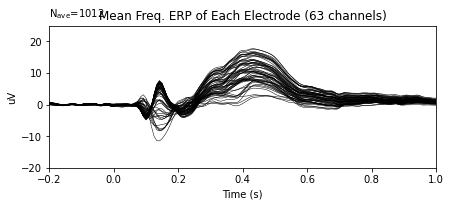

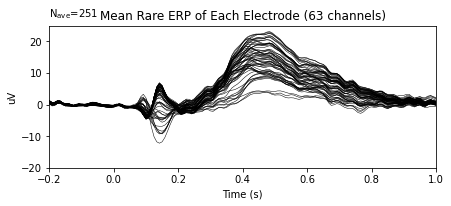

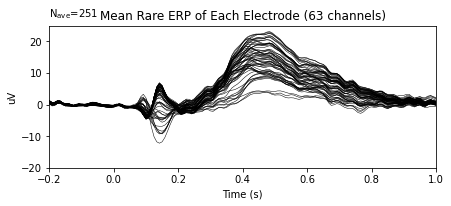

In [4]:
from mne import Epochs
rare = epochs['20_Dig_L', '20_Dig_R', '20_Let_L', '20_Let_R']
frequent = epochs['80_Dig_L', '80_Dig_R', '80_Let_L', '80_Let_R']
rare_ERP = rare.average()
freq_ERP = frequent.average()
freq_ERP.plot(titles = 'Mean Freq. ERP of Each Electrode', ylim = dict(eeg=[-20, 25]))
rare_ERP.plot(titles = 'Mean Rare ERP of Each Electrode', ylim = dict(eeg=[-20, 25]))

#### Compare evoked potentials
Using `mne.viz.plot_evoked_topo`, plot a comparison of all the evoked potentials across the scalp.

Avg. Freq Trials


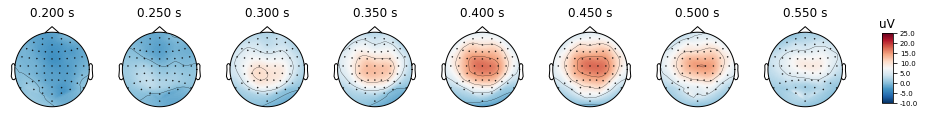

Avg. Rare Trials


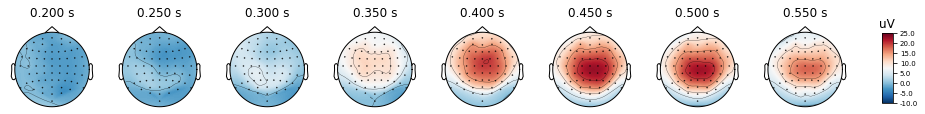

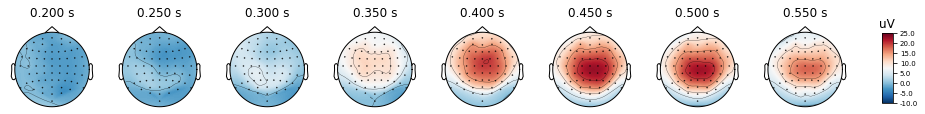

In [5]:
from mne.viz import plot_evoked_topo, plot_topomap

# I prefer the look of plot_topomap but uncomment below if you want to see the plot_evoked_topo

# plot_evoked_topo(rare_ERP, ylim = dict(eeg=[-20, 25]))
# plot_evoked_topo(freq_ERP, ylim = dict(eeg=[-20, 25]))

print('Avg. Freq Trials')
freq_ERP.plot_topomap(times = np.arange(0.2,0.6,0.05), vmin = -10, vmax = 25)
print('Avg. Rare Trials')
rare_ERP.plot_topomap(times = np.arange(0.2,0.6,0.05), vmin = -10, vmax = 25)

**Q**: Is there an obvious P300?

> &nbsp; **A**: I see a larger response to the rare events (12uV) compared to the frequent (8uV). Not sure if obvious, but it is there.

**Q**: If there is a P300, is it prominent everywhere?

> &nbsp; **A**: The largest response seems to be in the parietal lobe, directly on top of the scalp.

#### Topographic plots
Make topographic plots for the **difference wave**  Remember that the P300 should start around 300 ms and persist for many hundreds of milliseconds.

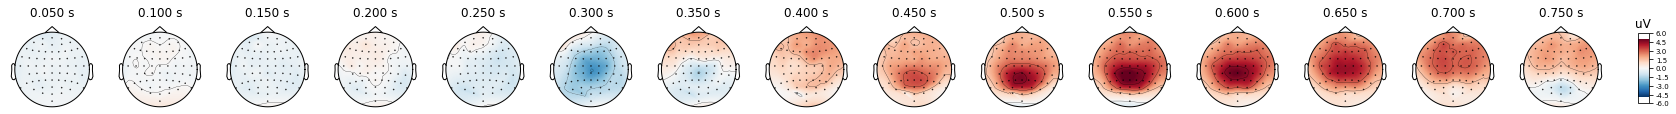

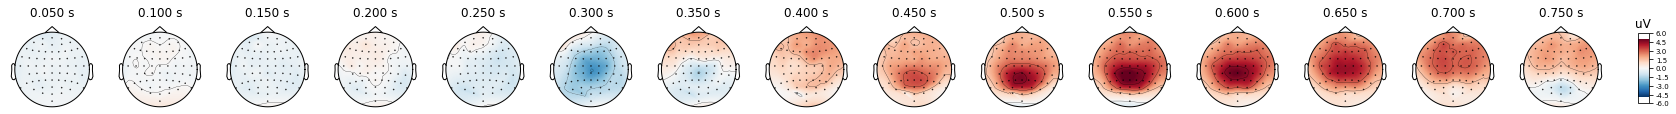

In [6]:
from mne import combine_evoked

# Make differences for each electrode's ERP across rare and freq trials
diff_wave = combine_evoked([rare_ERP, -freq_ERP], weights='equal')
diff_wave.plot_topomap(times = np.arange(0.05,0.8,0.05), vmin = -5, vmax = 5)

**Q**: If present, when is the P300 most prominent?

> &nbsp; **A**: 0.4 to 0.7s

**Q**: If present, where is the P300 most prominent?

> &nbsp; **A**: It starts more rostrally but is predominantly in the medial/caudal area at 0.45s onward.

### Step 1b: replication and permutation testing

In this final step, we will formalize our analysis by replicating and extending Figure 2 from [Luck et al., (2009)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-8986.2009.00817.x). To do so, we will perform permutation testing, testing for differences in the amplitude of the P300 between conditions across three sets of channels.

First, make two separate epoch objects:
- *frequent*: all the frequent (80)
- *rare*: all the rare (20) trials

In [7]:
# these objects were made before: rare and frequent
print(rare)
print(frequent)

<EpochsFIF  |   251 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~17.6 MB, data loaded,
 '20_Dig_L': 63
 '20_Dig_R': 60
 '20_Let_L': 64
 '20_Let_R': 64>
<EpochsFIF  |   1012 events (all good), -0.2 - 1 sec, baseline [-0.2, 0], ~70.7 MB, data loaded,
 '80_Dig_L': 254
 '80_Dig_R': 254
 '80_Let_L': 253
 '80_Let_R': 251>


Next, find the corresponding indices for the following sets of channels. Find the indices using `mne.pick_channels`. 
- frontal: F1, Fz, F2
- central: C3, Cz, C4
- parietal: P3, Pz, P4

In [8]:
from mne import pick_channels

front_chs = epochs.copy().pick_channels(['F1', 'Fz', 'F2'])
cent_chs = epochs.copy().pick_channels(['C3', 'Cz', 'C4'])
pari_chs = epochs.copy().pick_channels(['P3', 'Pz', 'P4'])

print(pari_chs.info)

<Info | 19 non-empty fields
    bads : list | 0 items
    ch_names : list | P3, Pz, P4
    chs : list | 3 items (EEG: 3)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 64 items
    events : list | 0 items
    file_id : dict | 4 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 60.0 Hz
    meas_date : NoneType | unspecified
    meas_id : dict | 4 items
    nchan : int | 3
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 120.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_layout : NoneType
>


Following the permutation testing code presented in the `eeg-02` demo, write a *for loop* that performs the following for each channel set:

1. Extracts the trials by channel set and condition (frequent, rare).
2. Average over the channels.
3. Performs permutation testing with 1024 permutations.
4. Plots the evoked potential (i.e. average over trials) per condition and highlights significant clusters.

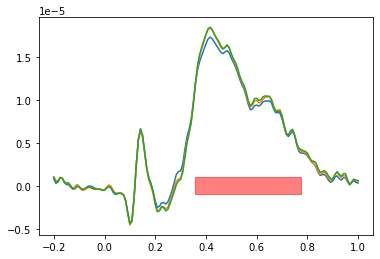

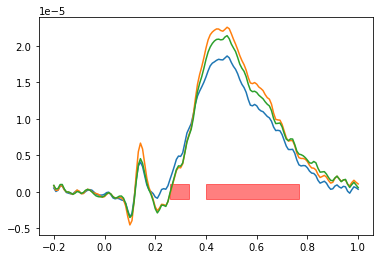

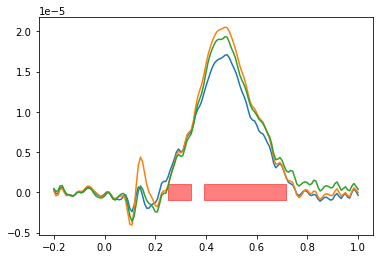

In [9]:
from mne.stats import permutation_cluster_test

ch_sets = [front_chs, cent_chs, pari_chs]
for ch in ch_sets:
    # Get data across conditions
    freq_data = ch['80_Dig_L', '80_Dig_R', '80_Let_L', '80_Let_R'].get_data().squeeze()
    rare_data = ch['20_Dig_L', '20_Dig_R', '20_Let_L', '20_Let_R'].get_data().squeeze()
    data = [rare_data, freq_data]
    F_obs, clusters, cluster_pv, H0 = permutation_cluster_test(data, n_permutations=1024, seed=47404, verbose=False)

    ## Plot clusters with red bar for significant portions
    mean_data = np.mean(rare_data, axis = 0)
    plt.figure()
    plt.plot(ch.times,mean_data.T)
    for cluster, pval in zip(clusters, cluster_pv): 
        if pval < 0.05:
            center = ch.times[cluster[0]].mean()
            plt.fill_between(ch.times[cluster[0]], -1e-6, 1e-6, color='r', alpha=0.5)
            

## Part 2

In the previous section, you measured the P300 in response to rare trials. During rare trials, participants need to inhibit a prepotent motor response (i.e. responding as if they saw a frequent trial). The need for motor inhibition is often said to generate a conflict signal. In scalp EEG, conflict signals are detectable as increases in non-phase-locked theta (4-8 Hz) power. In this final section, you will follow the steps as detailed in [Cohen & Donner (2013)](https://www.physiology.org/doi/full/10.1152/jn.00479.2013) to measure the theta signature of conflict in rare trials.

### Step 2a: spectral decomposition

With the epochs loaded, you will perform a spectral decomposition on the data to measure the time-frequency content of the data. Following [Cohen & Donner (2013)](https://www.physiology.org/doi/full/10.1152/jn.00479.2013), you will use Morlet wavelet decomposition. 

First you need to define the frequencies you want to measure. Using `np.logspace`, generate a vector of 12 logarithmically-spaced frequencies beginning at 4 Hz and ending at 30 Hz. (Note: If you do this correctly, your vector should start and end with 4 and 30, respectively.)

In [10]:
freq_space = np.logspace(np.log10(4), np.log10(30), 12)
print(freq_space)

[ 4.          4.80408868  5.769817    6.92967813  8.32269706  9.99574368
 12.00510976 14.41840296 17.3168216  20.79788664 24.97872293 30.        ]


In this next section, you are going to perform the spectral decomposition. The challenge is that you will need to measure non-phase-locked power. In other words, you are decomposing the epochs after the evoked potential has been subtracted. Importantly, this subtraction must occur within each condition. 

To assist you, we have started a for loop. In each cycle of the for loop, you will perform the following steps:

1. Make copy of the per-condition epochs.
2. Subtract evoked potential from copy.
3. Perform Morlet wavelet decomposition on the evoked-subtracted copy using the following parameters:
    - `freqs`: as defined above
    - `n_cycles`: 3
    - `return_itc`: False
4. Apply a baseline transformation to the power estimates making sure to:
    - Baseline correct (-0.1, 0.0)
    - Convert power into decibels.

In [11]:
from mne.time_frequency import tfr_morlet

# Define conditions
conditions = ['20_Dig_L', '20_Dig_R', '20_Let_L', '20_Let_R',
              '80_Dig_L', '80_Dig_R', '80_Let_L', '80_Let_R']

# Main loop
spectral = []
for k in conditions:

    ## Make temporary copy.
    trials = epochs[k].copy()
    
    ## Subtract evoked.
    sub_epoch = trials.subtract_evoked()
    
    ## Perform Morlet-based time-frequency decomposition.
    morlet = tfr_morlet(sub_epoch, freq_space, 3, return_itc=False, verbose=False)
    
    ## Apply baseline transformation.
    baseline = (-0.150, -0.050)
    method = 'logratio'
    morlet_pow = morlet.apply_baseline(baseline, method)
    morlet_pow_arr = 10 * morlet_pow.data
    
    ## Store.
    spectral.append(morlet_pow_arr)
    
# Convert to NumPy array
spectral = np.array(spectral)

### Step 2b: compute averages 

Using the power estimates defined above, create an average spectrogram for the frequent and rare trials.

(8, 63, 12, 145)


Text(0.5, 0, 'Time (samples)')

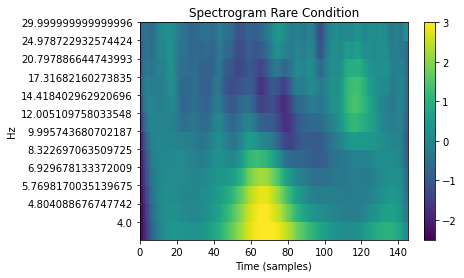

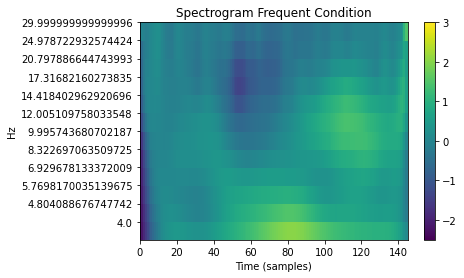

In [12]:
print(np.shape(spectral))

# Plotting average frequencies across electrodes over time for each condition

# Rare Trials
plt.figure()
rare_spec = spectral[0:3,:,:,:]
rare_spec = np.mean(rare_spec, axis = 0)
rare_spec = np.mean(rare_spec, axis = 0)
plt.pcolor(rare_spec, vmin = -2.5, vmax = 3)
plt.colorbar()
plt.yticks(ticks = np.linspace(1,12,12), labels = freq_space)
plt.title('Spectrogram Rare Condition')
plt.ylabel('Hz')
plt.xlabel('Time (samples)')

# Frequent Trials
plt.figure()
freq_spec = spectral[4:8,:,:,:]
freq_spec = np.mean(freq_spec, axis = 0)
freq_spec = np.mean(freq_spec, axis = 0)
plt.pcolor(freq_spec, vmin = -2.5, vmax = 3)
plt.colorbar()
plt.yticks(ticks = np.linspace(1,12,12), labels = freq_space)
plt.title('Spectrogram Frequent Condition')
plt.ylabel('Hz')
plt.xlabel('Time (samples)')

### Step 2c: visualize spectrograms

#### Frequent trials

Plot the spectrogram of the frequent trials for channel FCz using your favorite heatmap function.

Text(0.5, 0, 'Time (samples)')

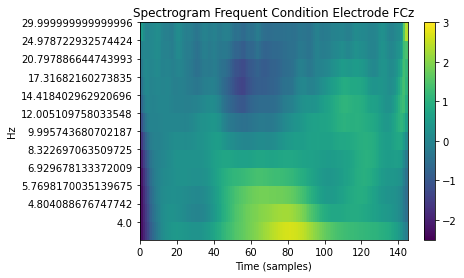

In [13]:
ind = epochs.ch_names.index('FCz')
FCz_spec = spectral[4:8,ind,:,:]
freq_spec = np.mean(FCz_spec, axis = 0)
plt.pcolor(freq_spec, vmin = -2.5, vmax = 3)
plt.colorbar()
plt.yticks(ticks = np.linspace(1,12,12), labels = freq_space)
plt.title('Spectrogram Frequent Condition Electrode FCz')
plt.ylabel('Hz')
plt.xlabel('Time (samples)')

#### Rare trials

Plot the spectrogram of the rare trials for channel FCz using your favorite heatmap function.

Text(0.5, 0, 'Time (samples)')

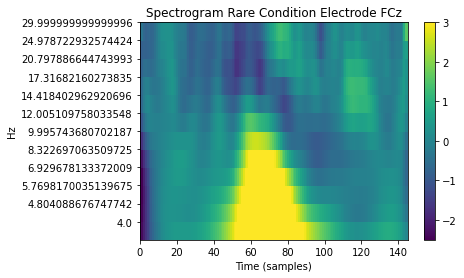

In [14]:
ind = epochs.ch_names.index('FCz')
FCz_spec = spectral[0:3,ind,:,:]
freq_spec = np.mean(FCz_spec, axis = 0)
plt.pcolor(freq_spec, vmin = -2.5, vmax = 3)
plt.colorbar()
plt.yticks(ticks = np.linspace(1,12,12), labels = freq_space)
plt.title('Spectrogram Rare Condition Electrode FCz')
plt.ylabel('Hz')
plt.xlabel('Time (samples)')

#### Rare - frequent trials

Plot the spectrogram of the rare - frequent trials for channel FCz using your favorite heatmap function.

Text(0.5, 0, 'Time (samples)')

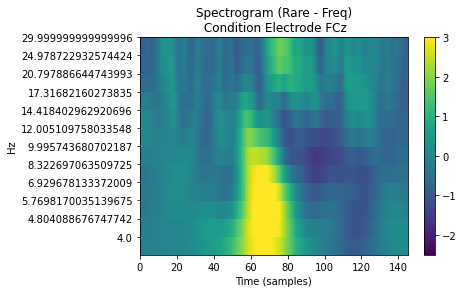

In [15]:
ind = epochs.ch_names.index('FCz')
FCz_spec = spectral[0:3,ind,:,:]
FCz_spec_rare = np.mean(FCz_spec, axis = 0)
FCz_spec = spectral[4:8,ind,:,:]
FCz_spec_freq = np.mean(FCz_spec, axis = 0)
plt.pcolor(FCz_spec_rare - FCz_spec_freq, vmin = -2.5, vmax = 3)
plt.colorbar()
plt.yticks(ticks = np.linspace(1,12,12), labels = freq_space)
plt.title('Spectrogram (Rare - Freq)\n Condition Electrode FCz')
plt.ylabel('Hz')
plt.xlabel('Time (samples)')

**Q:** Is there an increase in theta power between frequent and rare trials? If so, where?

> &nbsp; **A**: At sample 60 (about 0.4s) there is an increase in theta power in response to the rare condition, when compared to the frequent.

**Q:** Does the plot above resemble the non-phase-locked power from the midfrontal electrode (FCz) in Figure 2 of [Cohen & Donner (2013)](https://www.physiology.org/doi/full/10.1152/jn.00479.2013)?

> &nbsp; **A**: It kind of looks like Figure 2, but without the trough in power from 12-30Hz.


## Part 3

The final question on this problem set is about experimental design.

You've just received a manuscript for review from an eminent  neuroeconomics researcher who claims to have discovered an ERP that registers when someone learns about a potentially lucrative financial opportunity. You turn a critical eye towards the paper, and see that the results have probably been over-interpreted. 

Here is the design: A computer presented numbers on a screen representing the quantity that may be won or lost on a given trial. If the amount was positive, the numbers were green. If the amount was negative, the numbers were red. The subject was asked to press a button if they wanted to “place a bet”. The cost of a bet was \\$0.01. If the subject chose to place a bet, two seconds after their response they were informed as to whether they won. 80% of the time they won the promised amount, but 20% of the time they won or lost a random amount between -\\$10 and \\$10. The average payout on positive trials was \\$6, and the average loss on negative trials was \\$5. A payout or loss only occurred if the subject placed a bet. To simulate the negative bias of the financial media, only 10% of trials were positive, while 90% were negative. 

The results: Behaviorally, subjects bet on 95% of positive trials and only 1% of negative trials. There is an ERP for the green positive numbers that peaks at about 210 ms over parietal cortex. The stimulus-locked ERP pattern evoked by the colored number looks like this: 

![](images/part3-figure.png)

(Note that negative voltages are plotted here as positive on the Y axis as per traditional practice—and that's not a mistake or a confound.) 


**Q:** Name at least two possible confounds with this experiment. (One extra-credit point can be earned by naming three confounds.)

> &nbsp; **A**: 1. The study has a problem in dissociating making the betting action from positive and negative results. Right now, we can't tell if the ERP is because the result is positive, or that the subject has a bet in progress. This could be fixed by making the betting constant and only signalling different probabilities of success with the different colors. 2. I think the media bias is useless and artificially subsamples positive trials. This could be problematic for statistical analysis, but it also could induce a P300 response, as this task turns into a pseudo-oddball paradigm.